<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Construção e Deploy de Agentes de IA</font>
## <font color='blue'>Estudo de Caso 2</font>
### <font color='blue'>LangGraph Para Construção de Agentes de IA - Ferramentas, Memória, Estado, Workflow e Human-in-the-Loop</font>

In [1]:
# Imports
import json
import typing
import ollama
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END
from pydantic import BaseModel 
from pprint import pprint
from IPython.display import Image, display

## Definindo o LLM Open-Source com Ollama

In [2]:
# Nome do LLM
llm_opensource = "llama3.2"

In [3]:
# Questão para o LLM
q = '''Quem foi eleito Presidente dos EUA em 2024?'''

In [4]:
# Envia a pergunta ao LLM
resultado = ollama.chat(model = llm_opensource, 
                        messages = [{"role":"system", "content":""},
                                    {"role":"user", "content":q}])

In [5]:
print(resultado)

model='llama3.1' created_at='2025-03-01T01:25:58.355834Z' done=True done_reason='stop' total_duration=2519498041 load_duration=559289208 prompt_eval_count=25 prompt_eval_duration=1442000000 eval_count=21 eval_duration=276000000 message=Message(role='assistant', content='Não tenho acesso a informações atuais ou futuras, incluindo resultados de eleições.', images=None, tool_calls=None)


## Definindo as Ferramentas

No contexto do LangGraph, ferramentas são funções externas que os nós do grafo podem chamar para executar tarefas específicas, como fazer buscas na web, interagir com APIs ou manipular dados. Elas permitem que o fluxo de conversação do LangGraph acesse funcionalidades externas, tornando os agentes mais dinâmicos e capazes de lidar com diferentes tipos de solicitações.

In [6]:
@tool("dsa_tool_busca")
def dsa_tool_busca(q:str) -> str:
    """Pesquise no navegador DuckDuckGo passando a entrada `q`"""
    return DuckDuckGoSearchRun().run(q)

In [7]:
# Testando
print(dsa_tool_busca.invoke(q))

Eleitores dos EUA foram às urnas na terça-feira (5/11) e elegeram Donald Trump como o novo presidente e sucessor do democrata Joe Biden no comando da Casa Branca (acompanhe ao vivo as notícias ... Foi lá que o ex-presidente nasceu, em 1946, e viveu durante a infância e a adolescência. Trump filho queria construir prédios altos em Manhattan e hotéis, campos de golfe e cassinos fora dos EUA. Trump é eleito presidente dos EUA: veja que Estados votaram no republicano ou em Kamala Harris 5 novembro 2024 O candidato republicano Donald Trump venceu a eleição para presidente dos Estados ... Resultado da eleição dos EUA: veja votos por estado e quem está na frente ... que foi presidente de 2017 a 2020. ... um candidato precisa obter ao menos 270 dos 538 votos do Colégio Eleitoral ... GERADO EM: 06/11/2024 - 07:12 . ... Quem está na frente nas eleições dos Estados Unidos? ... O discurso de Trump: veja o que disse o presidente eleito dos EUA.


In [8]:
@tool("dsa_tool_resposta_final")
def dsa_tool_resposta_final(text:str) -> str:
    """Retorne uma resposta em linguagem natural ao usuário passando o `texto de entrada`. 
    Você deve fornecer o máximo de contexto possível e especificar a fonte da informação.
    """
    return text

In [9]:
# Testando
print( dsa_tool_resposta_final.invoke("Teste") )

Teste


In [10]:
# Dicionário de ferramentas
dic_tools = {"dsa_tool_busca":dsa_tool_busca, 
             "dsa_tool_resposta_final":dsa_tool_resposta_final}

## Adicionando as Ferramentas Para o Processo de Tomada de Decisão do Agente

In [11]:
# Cria o prompt
prompt = """
Você é especialista em notícias, você deve responder a todas as perguntas do usuário, você pode usar a lista de ferramentas fornecidas a você.
Seu objetivo é fornecer ao usuário a melhor resposta possível, incluindo informações importantes sobre as fontes e ferramentas usadas.

Observe que, ao usar uma ferramenta, você fornece o nome da ferramenta e os argumentos a serem usados no formato JSON.
Para cada chamada, você DEVE usar APENAS uma ferramenta e o formato de resposta DEVE SEMPRE seguir o padrão:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Lembre-se, NÃO use nenhuma ferramenta com a mesma consulta mais de uma vez.
Lembre-se, se o usuário não fizer uma pergunta específica, você DEVE usar a ferramenta `dsa_tool_resposta_final` diretamente.

Toda vez que o usuário faz uma pergunta, você anota na memória.
Toda vez que você encontra alguma informação relacionada à pergunta do usuário, você anota na memória.

Você deve tentar coletar informações de diversas fontes antes de fornecer a resposta ao usuário.
Depois de coletar informações suficientes para responder à pergunta do usuário, use a ferramenta `dsa_tool_resposta_final`.
"""

In [12]:
# Define a string com as ferramentas
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

In [13]:
print(str_tools)

1. `dsa_tool_busca`: Pesquise no navegador DuckDuckGo passando a entrada `q`
2. `dsa_tool_resposta_final`: Retorne uma resposta em linguagem natural ao usuário passando o `texto de entrada`. 
    Você deve fornecer o máximo de contexto possível e especificar a fonte da informação.


In [14]:
# Cria o prompt de ferramentas
prompt_tools = f"Você pode usar as seguintes ferramentas:\n{str_tools}"
print(prompt_tools)

Você pode usar as seguintes ferramentas:
1. `dsa_tool_busca`: Pesquise no navegador DuckDuckGo passando a entrada `q`
2. `dsa_tool_resposta_final`: Retorne uma resposta em linguagem natural ao usuário passando o `texto de entrada`. 
    Você deve fornecer o máximo de contexto possível e especificar a fonte da informação.


In [15]:
# Adicionando ferramentas ao LLM
dsa_resposta_llm = ollama.chat(model = llm_opensource,
                               messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                                           {"role":"user", "content":q}
                                        ], 
                               format = "json")

In [16]:
dsa_resposta_llm["message"]["content"]

'{"name":"dsa_tool_busca", "parameters":{"q":"eleição presidencial nos EUA 2024"}}'

In [17]:
# Extrai o conteúdo da resposta do LLM
content = dsa_resposta_llm["message"]["content"]
data = json.loads(content)

# Verifica as chaves presentes em 'parameters'
parameters = data.get("parameters", {})
print("Chaves em 'parameters':", parameters.keys())

# Tente obter o valor de 'q' ou 'texto de entrada'
tool_input = parameters.get('q') or parameters.get('texto de entrada')
if tool_input is None:
    raise KeyError("Nenhuma das chaves 'q' ou 'texto de entrada' foi encontrada em 'parameters'.")

print("Valor de tool_input:", tool_input)

Chaves em 'parameters': dict_keys(['q'])
Valor de tool_input: eleição presidencial nos EUA 2024


In [18]:
# Testa a ferramenta com o contexto
context = dsa_tool_busca.invoke(tool_input)
print("Contexto:\n", context)

Contexto:
 Trump vence eleições nos EUA: confira resultados em tempo real em mapas interativos ... Resultados nacionais das eleições presidenciais ... todos os 435 assentos estão em disputa na eleição ... Inicialmente, a eleição era uma revanche de 2020, ... 3 de 3 Linhas médias de pesquisas de intenção de voto para as Eleições Presidenciais nos EUA de 2024 — Foto: BBC . View live election results from the 2024 presidential race as Kamala Harris and Donald Trump face off. See the map of votes by state as results are tallied. Se um empate no Colégio Eleitoral forçar uma eleição contingente, cada estado recebe um voto, e uma maioria simples de 26 votos elegeria o novo presidente. Os republicanos atualmente têm a maioria nas delegações da Câmara dos EUA de 26 estados, e essa vantagem pode aumentar, de acordo com as projeções para as eleições dos deputados ... Veja quais são as principais datas das eleições nos Estados Unidos em 2024 . Durante todo o ano, EUA realizaram votações primárias 

## Criando a Estrutura do Agente
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
No LangGraph, um agente pode ser implementado como uma classe. Isso é útil para encapsular a lógica do agente, incluindo a definição de nós, transições e o uso de memória e ferramentas.

Ao definir um agente como uma classe, você pode:

- Estruturar melhor o código, separando a lógica da execução do grafo.
- Armazenar estados internos e configurar o fluxo de decisão de maneira mais organizada.
- Facilitar a reutilização e escalabilidade do agente.

In [19]:
# Classe do Agente
class DSAAgent(BaseModel):
    
    # Nome da ferramenta usada pelo agente
    tool_name: str  
    
    # Entrada fornecida para a ferramenta (parâmetros)
    tool_input: dict  
    
    # Resultado retornado pela ferramenta, opcionalmente pode ser None
    tool_output: str | None = None  
    
    # Método de classe para criar instância a partir da resposta do modelo (LLM)
    @classmethod
    def from_llm(cls, res: dict):  
        try:
            # Decodifica o conteúdo JSON da resposta do LLM
            out = json.loads(res["message"]["content"])
            # Retorna uma nova instância da classe com os dados extraídos
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            # Imprime erro caso ocorra falha no processamento
            print(f"Erro do Ollama:\n{res}\n")
            raise e

In [20]:
# Testando o Agente
agente_dsa = DSAAgent.from_llm(dsa_resposta_llm)
print("Formato Inicial:\n", dsa_resposta_llm["message"]["content"], "\nFormato do Agente:")
agente_dsa

Formato Inicial:
 {"name":"dsa_tool_busca", "parameters":{"q":"eleição presidencial nos EUA 2024"}} 
Formato do Agente:


DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'eleição presidencial nos EUA 2024'}, tool_output=None)

In [21]:
# Testando a ferramenta
DSAAgent(tool_name = "dsa_tool_busca", 
         tool_input = {'q':'Quem foi eleito Presidente nos EUA em 2024?'}, 
         tool_output = str( dsa_tool_busca.invoke(tool_input)) )

DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'Quem foi eleito Presidente nos EUA em 2024?'}, tool_output='Trump vence eleições nos EUA: confira resultados em tempo real em mapas interativos ... Resultados nacionais das eleições presidenciais ... todos os 435 assentos estão em disputa na eleição ... View live election results from the 2024 presidential race as Kamala Harris and Donald Trump face off. See the map of votes by state as results are tallied. Eleições nos EUA 2024. ... Faltando menos de 10 dias para as eleições presidenciais nos Estados ... Para vencer a eleição nos Estados Unidos é necessário conquistar 270 dos 538 delegados ... A 5 dias da eleição presidencial nos EUA, o que dizem as pesquisas? Levantamento mostra Kamala Harris com vantagem mínima sobre Donald Trump na Carolina do Norte, tradicionalmente republicana . Jorge Fernando Rodrigues Danilo Cruz. 01/11/2024 às 00:48 | Atualizado 01/11/2024 às 13:33 Por que apuração dos votos da eleição dos EUA tem tudo par

## Configurando a Memória do Sistema
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
No LangGraph, a memória refere-se à capacidade de armazenar e recuperar informações ao longo da execução do fluxo de conversação. Isso permite que o agente mantenha contexto entre interações, lembre-se de dados do usuário e ajuste suas respostas com base em interações anteriores. A memória pode ser implementada de diferentes formas, como armazenando variáveis no estado do grafo ou integrando soluções externas de armazenamento.

In [22]:
# Função para gerar memória contextual do Agente
def dsa_memoria_agente(lst_res: list[DSAAgent], user_q: str) -> list:

    # Inicializa a memória vazia
    memory = []
    
    # Itera sobre respostas anteriores que possuem uma saída válida
    for res in [res for res in lst_res if res.tool_output is not None]:
        
        # Adiciona à memória a interação da ferramenta usada pelo assistente
        memory.extend([
            {"role": "assistant", "content": json.dumps({"name": res.tool_name, "parameters": res.tool_input})},
            {"role": "user", "content": res.tool_output}
        ])
    
    # Se a memória não estiver vazia, adiciona um lembrete da pergunta original
    if memory:
        memory += [{"role": "user", "content": (f'''
                Este é apenas um lembrete de que minha consulta original era `{user_q}`.
                Responda apenas à pergunta original e nada mais, mas use as informações que lhe dei.
                Forneça o máximo de informações possível ao usar a ferramenta `final_answer`.
                ''')}]

    # Retorna a memória atualizada
    return memory

In [23]:
# Cria uma lista de histórico para o chat
chat_history = [{"role": "user", "content": "Olá, tudo bem?"},
                {"role": "assistant", "content": "Estou bem, obrigado!"},
                {"role": "user", "content": "Eu tenho uma pergunta"},
                {"role": "assistant", "content": "Sim, o que você gostaria de saber?"}]

## Configurando a Execução do Agente

In [24]:
# Função que executa o agente com base no prompt e nas ferramentas disponíveis
def dsa_executa_agente(prompt: str, 
                       dic_tools: dict, 
                       user_q: str, 
                       chat_history: list[dict], 
                       lst_res: list[DSAAgent]) -> DSAAgent:
    
    # Inicializa a memória com as respostas anteriores do agente
    memory = dsa_memoria_agente(lst_res = lst_res, user_q = user_q)
    
    # Verifica se todas as ferramentas já foram utilizadas, forçando o uso da resposta final
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "Agora você deve usar a ferramenta `dsa_tool_resposta_final`."

    # Formata a lista de ferramentas disponíveis para o prompt
    str_tools = "\n".join([
        f"{n+1}. `{v.name}`: {v.description}" 
        for n, v in enumerate(dic_tools.values())
    ])
    
    prompt_tools = f"Você pode usar as seguintes ferramentas:\n{str_tools}"
        
    # Constrói a lista completa de mensagens (prompt + histórico + memória)
    messages = [
        {"role": "system", "content": prompt + "\n" + prompt_tools},
        *chat_history,
        {"role": "user", "content": user_q},
        *memory
    ]
    
    # Realiza a chamada ao modelo LLM com o conteúdo gerado
    llm_res = ollama.chat(model = llm_opensource, 
                          messages = messages, 
                          format = "json")
    
    # Retorna o resultado como uma instância de DSAAgent
    return DSAAgent.from_llm(llm_res)

In [25]:
# Testando
agent_res = dsa_executa_agente(prompt = prompt, 
                               dic_tools = dic_tools, 
                               user_q = q, 
                               chat_history = chat_history, 
                               lst_res = [])
print("Resposta do Agente:", agent_res)

Resposta do Agente: tool_name='dsa_tool_busca' tool_input={'q': 'eleição presidencial EUA 2024 resultado'} tool_output=None


## Criando os Componentes do Graph Workflow

O Graph Workflow no LangGraph é a estrutura que define como as interações fluem entre os nós do grafo. Ele representa a lógica do agente como um grafo direcionado, onde cada nó pode executar uma função e cada aresta define possíveis transições para os próximos passos.

### Estado

No LangGraph, o estado é a estrutura de dados que mantém o contexto ao longo da execução do fluxo. Ele armazena informações relevantes, como entradas do usuário, saídas de funções e variáveis persistentes que influenciam o comportamento do agente.

In [26]:
# Classe de Estado
class State(typing.TypedDict):

    # Pergunta original feita pelo usuário
    user_q: str
    
    # Histórico completo da conversa
    chat_history: list 
    
    # Lista de respostas anteriores do agente
    lst_res: list[DSAAgent]
    
    # Resultado final ou saída produzida pelo agente
    output: dict

In [27]:
# Testando
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'Quem foi eleito Presidente dos EUA em 2024?',
 'chat_history': [{'role': 'user', 'content': 'Olá, tudo bem?'},
  {'role': 'assistant', 'content': 'Estou bem, obrigado!'},
  {'role': 'user', 'content': 'Eu tenho uma pergunta'},
  {'role': 'assistant', 'content': 'Sim, o que você gostaria de saber?'}],
 'lst_res': [DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'eleição presidencial EUA 2024 resultado'}, tool_output=None)],
 'output': {}}

### Node (Nó)

No LangGraph, um node (nó) é uma unidade de processamento dentro do Graph Workflow. Cada nó executa uma função específica e pode modificar o estado antes de passar a execução para outro nó.

In [28]:
# Criando o Agente Node
def dsa_agente_node(state):
    
    # Indica início da execução do node agente
    print("--- Agente Node ---")
    
    # Executa o agente usando a função dsa_executa_agente com o prompt e ferramentas especificadas
    agent_res = dsa_executa_agente(
        prompt = prompt, 
        dic_tools = {k: v for k, v in dic_tools.items() if k in ["dsa_tool_busca", "dsa_tool_resposta_final"]},
        user_q = state["user_q"], 
        chat_history = state["chat_history"], 
        lst_res = state["lst_res"]
    )
    
    # Exibe o resultado obtido pelo agente
    print(agent_res)
    
    # Retorna o resultado encapsulado em um dicionário no formato esperado pelo fluxo
    return {"lst_res": [agent_res]}

In [29]:
# Testando
dsa_agente_node(state)

--- Agente Node ---
tool_name='dsa_tool_busca' tool_input={'q': 'Eleição presidencial nos Estados Unidos em 2024'} tool_output=None


{'lst_res': [DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'Eleição presidencial nos Estados Unidos em 2024'}, tool_output=None)]}

### Node Especializado

O node tool como dsa_agente_node_tool é um nó especializado no LangGraph responsável por processar chamadas de ferramentas (tools) dentro do fluxo do agente. Ele atua como um intermediário que:
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
- Identifica qual ferramenta foi chamada com base no estado (state["lst_res"][-1]).
- Extrai e valida os parâmetros necessários para a ferramenta funcionar corretamente.
- Invoca a ferramenta correspondente (dic_tools[res.tool_name].invoke(tool_input)).
- Retorna a saída de acordo com a ferramenta utilizada.

In [30]:
# Função para configurar as ferramentas do node do agente
def dsa_agente_node_tool(state):
    
    # Indica o início da execução da ferramenta do agente
    print("--- Agente Node Tool ---")
    
    # Captura o resultado mais recente do agente
    res = state["lst_res"][-1]
    
    # Exibe a ferramenta utilizada e os parâmetros passados
    print(f"{res.tool_name}(input = {res.tool_input})")

    # Verifica qual ferramenta está sendo utilizada e ajusta os parâmetros adequadamente
    if res.tool_name == "dsa_tool_resposta_final":
        # Lista de possíveis chaves para 'tool_input'
        possible_keys = ['text', 'texto de entrada', 'q', 'texto']
        tool_input = None
        for key in possible_keys:
            if key in res.tool_input:
                tool_input = res.tool_input[key]
                break
        
        # Validação de existência do parâmetro necessário
        if not tool_input:
            raise ValueError(f"Parâmetro necessário não encontrado para '{res.tool_name}'. Chaves esperadas: {possible_keys}. Chaves presentes: {list(res.tool_input.keys())}")
        
        # Cria a resposta do agente com a ferramenta 'dsa_tool_resposta_final'
        agent_res = DSAAgent(
            tool_name = res.tool_name,
            tool_input = {'text': tool_input},
            tool_output = str(dic_tools[res.tool_name].invoke(tool_input))
        )
    else:
        # Para outras ferramentas, assume-se que o parâmetro é 'q'
        possible_keys = ['q', 'texto de entrada', 'text', 'texto']
        tool_input = None
        for key in possible_keys:
            if key in res.tool_input:
                tool_input = res.tool_input[key]
                break
        
        # Validação de existência do parâmetro necessário
        if not tool_input:
            raise ValueError(f"Parâmetro necessário não encontrado para '{res.tool_name}'. Chaves esperadas: {possible_keys}. Chaves presentes: {list(res.tool_input.keys())}")
        
        # Cria a resposta do agente com outras ferramentas (não dsa_tool_resposta_final)
        agent_res = DSAAgent(
            tool_name = res.tool_name,
            tool_input = {'q': tool_input},
            tool_output = str(dic_tools[res.tool_name].invoke(tool_input))
        )

    # Retorna o resultado final caso seja 'dsa_tool_resposta_final', caso contrário retorna para continuar processamento
    return {"output": agent_res} if res.tool_name == "dsa_tool_resposta_final" else {"lst_res": [agent_res]}

In [31]:
# Testando
dsa_agente_node_tool(state)

--- Agente Node Tool ---
dsa_tool_busca(input = {'q': 'eleição presidencial EUA 2024 resultado'})


{'lst_res': [DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'eleição presidencial EUA 2024 resultado'}, tool_output='Eleitores dos EUA foram às urnas na terça-feira (5/11) e elegeram Donald Trump como o novo presidente e sucessor do democrata Joe Biden no comando da Casa Branca (acompanhe ao vivo as notícias ... View live election results from the 2024 presidential race as Kamala Harris and Donald Trump face off. See the map of votes by state as results are tallied. Consulte aqui os resultados das eleições dos Estados Unidos em tempo real. A informação é fornecida pela CNN Internacional para as votações para Presidente, Senado e Câmara dos Representantes. ... a história de ultraviolência do novo número 2 dos EUA 20 jan, 10:00 Um breve comunicado anuncia que só um dos Obamas é que vai à posse ... Hoje, 5 de novembro de 2024, os Estados Unidos realizam suas eleições presidenciais. Acompanhe a contagem de votos em tempo real. GERADO EM: 06/11/2024 - 07:12 Trump lidera eleições nos 

### Edges (Arestas) Condicionais

As edges condicionais determinam dinamicamente qual será o próximo nó (node) a ser executado no fluxo, com base no estado atual. Elas permitem que o grafo siga caminhos diferentes dependendo da lógica definida.

In [32]:
# Função para determinar os próximos nodes com base nas condições atuais do estado
def dsa_edges_condicionais(state):
    
    # Indica início da execução das condições das edges (transições)
    print("--- Edges Condicionais ---")
    
    # Obtém a última resposta do agente armazenada no estado
    last_res = state["lst_res"][-1]
    
    # Decide qual é o próximo node com base na ferramenta usada
    next_node = last_res.tool_name if isinstance(state["lst_res"], list) else "dsa_tool_resposta_final"
    
    # Exibe qual será o próximo node
    print("Próximo Node:", next_node)
    
    # Retorna o próximo node que deve ser executado
    return next_node

In [33]:
# Testando
dsa_edges_condicionais(state)

--- Edges Condicionais ---
Próximo Node: dsa_tool_busca


'dsa_tool_busca'

## Criando e Visualizando o Grafo

In [34]:
# Inicializa o grafo de estados usando a classe State
workflow = StateGraph(State)

# Adiciona o node principal do agente ao workflow
workflow.add_node(node = "AgenteDSA", action = dsa_agente_node)

# Define o ponto de entrada inicial do workflow 
workflow.set_entry_point(key = "AgenteDSA")

# Adiciona os nodes especializados das ferramentas disponíveis ao workflow
for k in dic_tools.keys():
    workflow.add_node(node = k, action = dsa_agente_node_tool)

# Adiciona edges condicionais partindo do node "AgenteDSA"
workflow.add_conditional_edges(source = "AgenteDSA", path = dsa_edges_condicionais)

# Adiciona edges que retornam ao node "AgenteDSA" após execução das ferramentas, exceto a resposta final
for k in dic_tools.keys():
    if k != "dsa_tool_resposta_final":
        workflow.add_edge(start_key = k, end_key = "AgenteDSA")

# Define uma edge final que termina o workflow após execução da ferramenta 'dsa_tool_resposta_final'
workflow.add_edge(start_key = "dsa_tool_resposta_final", end_key = END)

# Compila o workflow completo para execução
g = workflow.compile()

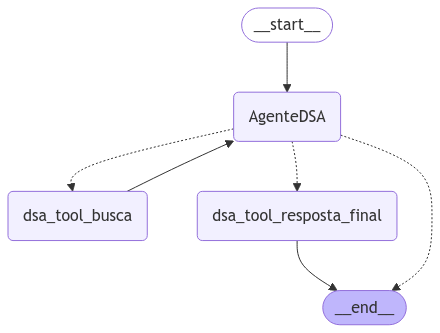

In [35]:
# Visualizando o workflow
display(Image(g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
### Executando o Workflow Com 1 Único Agente

In [36]:
# Estado inicial
initial_state = {'user_q':q,
                 'chat_history':chat_history, 
                 'lst_res':[],
                 'output':{} }

In [37]:
# Testando
out = g.invoke(input = initial_state)
agent_out = out['output'].tool_output

--- Agente Node ---
tool_name='dsa_tool_busca' tool_input={'q': 'eleição presidencial EUA 2024'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_busca
--- Agente Node Tool ---
dsa_tool_busca(input = {'q': 'eleição presidencial EUA 2024'})
--- Agente Node ---
tool_name='dsa_tool_resposta_final' tool_input={'texto de entrada': 'Kamala Harris foi eleita Presidente dos EUA em 2024, segundo os resultados das eleições presidenciais nos Estados Unidos em 5 de novembro. A informação foi fornecida pela imprensa e não há um órgão central que centralize a apuraÇão, como o Tribunal Superior Eleitoral (TSE) no Brasil. A fonte da informação é um artigo de notícias publicado no dia 5 de novembro de 2024.', 'fonte': 'Imprensa'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_resposta_final
--- Agente Node Tool ---
dsa_tool_resposta_final(input = {'texto de entrada': 'Kamala Harris foi eleita Presidente dos EUA em 2024, segundo os resultados das eleições presidenci

In [38]:
print("Resposta do Agente no Estado Inicial:")
agent_out

Resposta do Agente no Estado Inicial:


'Kamala Harris foi eleita Presidente dos EUA em 2024, segundo os resultados das eleições presidenciais nos Estados Unidos em 5 de novembro. A informação foi fornecida pela imprensa e não há um órgão central que centralize a apuraÇão, como o Tribunal Superior Eleitoral (TSE) no Brasil. A fonte da informação é um artigo de notícias publicado no dia 5 de novembro de 2024.'

In [39]:
# Loop pelos passos do workflow
passos = g.stream(input = initial_state) 
for n, passo in enumerate(passos):
    print("--- Passo", n, "---")
    print(passo)

--- Agente Node ---
tool_name='dsa_tool_busca' tool_input={'q': 'Presidente dos EUA eleito em 2024'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_busca
--- Passo 0 ---
{'AgenteDSA': {'lst_res': [DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'Presidente dos EUA eleito em 2024'}, tool_output=None)]}}
--- Agente Node Tool ---
dsa_tool_busca(input = {'q': 'Presidente dos EUA eleito em 2024'})
--- Passo 1 ---
{'dsa_tool_busca': {'lst_res': [DSAAgent(tool_name='dsa_tool_busca', tool_input={'q': 'Presidente dos EUA eleito em 2024'}, tool_output='Eleitores dos EUA foram às urnas na terça-feira (5/11) e elegeram Donald Trump como o novo presidente e sucessor do democrata Joe Biden no comando da Casa Branca (acompanhe ao vivo as notícias ... Trump é eleito presidente dos EUA, aponta projeção da AP ... 06/11/2024 07h35 Atualizado 11/11/2024 . ... que o alçou à fama antes de se tornar presidente dos EUA, em 2017. View live election results from the 2024 presidential r

## Configuração Multi-Agente e Human-in-the-Loop

A Configuração Multi-Agente no LangGraph refere-se ao uso de vários agentes dentro de um único grafo para colaborar e resolver tarefas complexas. Cada agente pode ter um papel específico e interagir dinamicamente no fluxo do grafo.

O Human-in-the-Loop (HITL) é uma abordagem onde humanos intervêm no fluxo do agente quando necessário. Isso é útil em casos que exigem supervisão, validação ou decisões que um modelo sozinho não pode tomar.

In [40]:
@tool("dsa_tool_wikipedia")
def dsa_tool_wikipedia(q:str) -> str:
    """Pesquise na Wikipédia passando a entrada `q`.
       A entrada `q` deve ser palavras-chave curtas, não um texto longo"""
    return WikipediaQueryRun(api_wrapper = WikipediaAPIWrapper()).run(q)

In [41]:
# Incui a nova ferramenta no dicionário de ferramentas
dic_tools = {"dsa_tool_busca":dsa_tool_busca,
             "dsa_tool_resposta_final":dsa_tool_resposta_final,
             "dsa_tool_wikipedia":dsa_tool_wikipedia}

In [42]:
# Cria o segundo prompt
prompt_2 = """
Seu objetivo é usar a `dsa_tool_wikipedia` APENAS UMA VEZ para enriquecer as informações já disponíveis.
Observe que, ao usar uma ferramenta, você fornece o nome da ferramenta e os argumentos a serem usados no formato JSON.
Para cada chamada, você DEVE usar APENAS uma ferramenta e o formato de resposta SEMPRE deve estar no padrão:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Primeiro você deve usar a `dsa_tool_wikipedia`, depois elaborar as informações para responder à pergunta do usuário com a ferramenta `dsa_tool_resposta_final`.
"""

In [43]:
# Função para execução do segundo node do agente no fluxo de trabalho
def dsa_agente_node_2(state):
    
    # Indica início da execução do segundo node do agente
    print("--- Agente Node 2 ---")
    
    # Executa o agente com um novo prompt (prompt_2) e um conjunto específico de ferramentas
    agent_res = dsa_executa_agente(
        prompt = prompt_2,
        dic_tools = {k: v for k, v in dic_tools.items() if k in ["dsa_tool_wikipedia", "dsa_tool_resposta_final"]},
        user_q = state["output"].tool_output,  # Utiliza o resultado do node anterior como entrada
        chat_history = state["chat_history"],
        lst_res = state["lst_res"]
    )
    
    # Exibe o resultado obtido do agente
    print(agent_res)
    
    # Retorna a nova resposta do agente no formato esperado pelo fluxo
    return {"lst_res": [agent_res]}

In [44]:
# Node aguardando interação humana (sem implementação automática)
def dsa_human_node(state):
    pass

In [45]:
# Edges condicionais para interação humana (tomada de decisão manual)
def dsa_human_edges(state):
    
    # Indica início da interação com o usuário
    print("--- Humano ---")
    
    # Solicita feedback humano para decidir se deve continuar ou parar o workflow
    user_feedback = input("Devo continuar? [s/n] --> ")
    
    # Decide o próximo node com base na resposta do usuário ('AgenteDSA2' ou fim do fluxo)
    next_node = "AgenteDSA2" if user_feedback.lower()[0] == "s" else END
    
    # Exibe qual será o próximo node baseado na decisão do usuário
    print("Próximo Node:", next_node)
    
    # Retorna o próximo node que será executado
    return next_node

In [46]:
# Testando
dsa_human_edges(state)

--- Humano ---


Devo continuar? [s/n] -->  s


Próximo Node: AgenteDSA2


'AgenteDSA2'

Vamos recriar o grafo.

In [47]:
# Inicializando o grafo de estados do workflow
workflow = StateGraph(State)

########################## Agente 1 ##########################

# Adiciona o primeiro node do agente ao workflow
workflow.add_node(node = "AgenteDSA1", action = dsa_agente_node) 

# Define o ponto de entrada inicial do workflow como "AgenteDSA1"
workflow.set_entry_point(key = "AgenteDSA1") 

# Adiciona nodes específicos das ferramentas ao workflow
workflow.add_node(node = "dsa_tool_busca", action = dsa_agente_node_tool)
workflow.add_node(node = "dsa_tool_resposta_final", action = dsa_agente_node_tool)

# Cria uma edge retornando da ferramenta 'busca' para o agente inicial
workflow.add_edge(start_key = "dsa_tool_busca", end_key = "AgenteDSA1")

# Adiciona edges condicionais partindo do node "AgenteDSA1"
workflow.add_conditional_edges(source = "AgenteDSA1", path = dsa_edges_condicionais)

########################## Humano ##########################

# Adiciona um node para interação humana no workflow
workflow.add_node(node = "Human", action = dsa_human_node)

# Adiciona uma edge condicional após 'resposta_final', decidida pelo usuário
workflow.add_conditional_edges(source = "dsa_tool_resposta_final", path = dsa_human_edges)

########################## Agente 2 ##########################

# Adiciona o segundo node do agente ao workflow
workflow.add_node(node = "AgenteDSA2", action = dsa_agente_node_2) 

# Adiciona o node da ferramenta 'wikipedia' ao workflow
workflow.add_node(node = "dsa_tool_wikipedia", action = dsa_agente_node_tool)

# Cria uma edge retornando da ferramenta 'wikipedia' para o Agente 2
workflow.add_edge(start_key = "dsa_tool_wikipedia", end_key = "AgenteDSA2")

# Adiciona edges condicionais partindo do node "AgenteDSA2"
workflow.add_conditional_edges(source = "AgenteDSA2", path = dsa_edges_condicionais)

########################## End ##########################

# Compila o workflow final para execução
g2 = workflow.compile()

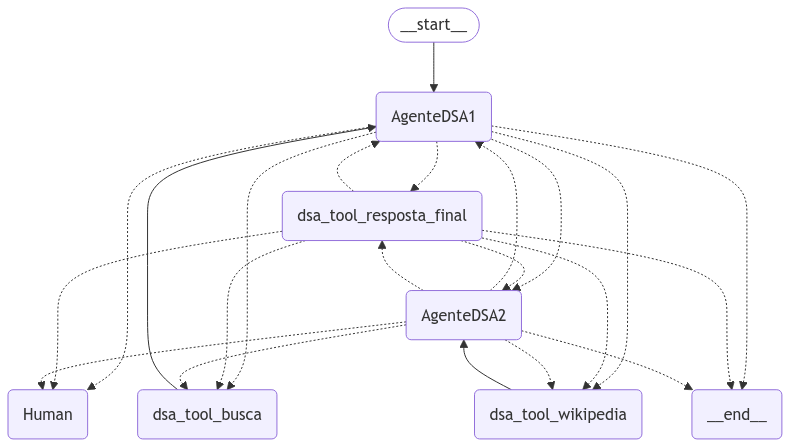

In [48]:
# Plot
display(Image(g2.get_graph().draw_mermaid_png(draw_method = MermaidDrawMethod.API)))

## Executando o Sistema Autônomo

In [49]:
# Estado inicial
initial_state

{'user_q': 'Quem foi eleito Presidente dos EUA em 2024?',
 'chat_history': [{'role': 'user', 'content': 'Olá, tudo bem?'},
  {'role': 'assistant', 'content': 'Estou bem, obrigado!'},
  {'role': 'user', 'content': 'Eu tenho uma pergunta'},
  {'role': 'assistant', 'content': 'Sim, o que você gostaria de saber?'}],
 'lst_res': [],
 'output': {}}

In [50]:
# Executa o workflow
out_2 = g2.invoke(input = initial_state)
agent_out_2 = out_2['output'].tool_output

--- Agente Node ---
tool_name='dsa_tool_busca' tool_input={'q': 'eleição presidencial EUA 2024'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_busca
--- Agente Node Tool ---
dsa_tool_busca(input = {'q': 'eleição presidencial EUA 2024'})
--- Agente Node ---
tool_name='dsa_tool_resposta_final' tool_input={'texto de entrada': 'Donald Trump foi eleito Presidente dos EUA em 2024, derrotando Kamala Harris, vice-presidente do atual presidente Joe Biden. A eleição ocorreu na tería-feira (5/11), e Donald Trump conquistou a presidência da Casa Branca.', 'fonte': 'O Globo'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_resposta_final
--- Agente Node Tool ---
dsa_tool_resposta_final(input = {'texto de entrada': 'Donald Trump foi eleito Presidente dos EUA em 2024, derrotando Kamala Harris, vice-presidente do atual presidente Joe Biden. A eleição ocorreu na tería-feira (5/11), e Donald Trump conquistou a presidência da Casa Branca.', 'fonte': 'O Globo'})
---

Devo continuar? [s/n] -->  s


Próximo Node: AgenteDSA2
--- Agente Node 2 ---
tool_name='dsa_tool_wikipedia' tool_input={'q': 'eleição 2024 nos EUA'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_wikipedia
--- Agente Node Tool ---
dsa_tool_wikipedia(input = {'q': 'eleição 2024 nos EUA'})
--- Agente Node 2 ---
tool_name='dsa_tool_resposta_final' tool_input={'texto de entrada': 'Donald Trump foi eleito Presidente dos EUA em 2024, derrotando Kamala Harris, vice-presidente do atual presidente Joe Biden. A eleição ocorreu na tería-feira (5/11), e Donald Trump conquistou a presidência da Casa Branca.', 'fonte': 'Informações disponibilizadas pela Wikipídia e outras fontes confiáveis'} tool_output=None
--- Edges Condicionais ---
Próximo Node: dsa_tool_resposta_final
--- Agente Node Tool ---
dsa_tool_resposta_final(input = {'texto de entrada': 'Donald Trump foi eleito Presidente dos EUA em 2024, derrotando Kamala Harris, vice-presidente do atual presidente Joe Biden. A eleição ocorreu na tería-feira (5/1

Devo continuar? [s/n] -->  n


Próximo Node: __end__


In [51]:
print("Obrigado Por Usar Este Time de Agentes DSA. Este é o Resultado da Sua Consulta:")
agent_out_2

Obrigado Por Usar Este Time de Agentes DSA. Este é o Resultado da Sua Consulta:


'Donald Trump foi eleito Presidente dos EUA em 2024, derrotando Kamala Harris, vice-presidente do atual presidente Joe Biden. A eleição ocorreu na tería-feira (5/11), e Donald Trump conquistou a presidência da Casa Branca.'

# Fim